In [1]:
import multiprocessing
multiprocessing.set_start_method("fork")

In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import arviz as az
import h5py
import pandas as pd
import seaborn as sns

import ringdown

sns.set_context('notebook')
sns.set_palette('colorblind')

Grad 4096s of the data:

In [ ]:
!wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126257415-4096.hdf5
!wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_16KHZ_R1-1126257415-4096.hdf5

If you have the right data, you should get the following MD5 hashes:
```
MD5(H-H1_GWOSC_16KHZ_R1-1126257415-4096.hdf5)= 9a853be0f769fd177d40880dbd56af62
MD5(L-L1_GWOSC_16KHZ_R1-1126257415-4096.hdf5)= 299f1ca9c089c4802d48f313ce2e6567
```

In [4]:
!openssl md5 H-H1_GWOSC_16KHZ_R1-1126257415-4096.hdf5
!openssl md5 L-L1_GWOSC_16KHZ_R1-1126257415-4096.hdf5

MD5(H-H1_GWOSC_16KHZ_R1-1126257415-4096.hdf5)= 9a853be0f769fd177d40880dbd56af62
MD5(L-L1_GWOSC_16KHZ_R1-1126257415-4096.hdf5)= 299f1ca9c089c4802d48f313ce2e6567


Now we make timeseries data objects out of the stored data:

In [5]:
def read_strain(file, dname):
    with h5py.File(file, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
    
        dt = T/len(h)
    
        raw_strain = ringdown.Data(h, index=t0 + dt*arange(len(h)), ifo=dname)
        
        return raw_strain
    
h_raw_strain = read_strain('H-H1_GWOSC_16KHZ_R1-1126257415-4096.hdf5', 'H1')
l_raw_strain = read_strain('L-L1_GWOSC_16KHZ_R1-1126257415-4096.hdf5', 'L1')

Now that we've got the strain loaded up, we want to condition it a bit.  LIGO does not have very good high-frequency sensitivity; also, our modes do not have a lot of high-frequency content.  Additionally, LIGO contains a lot of low-frequency noise and our templates do not have a lot of power at low frequencies.  Here are estimated noise PSDs for our data:

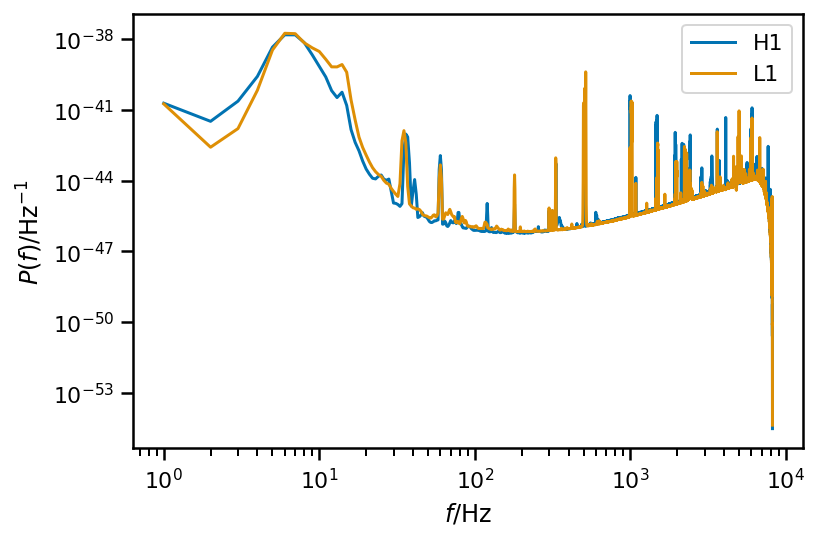

In [6]:
h_raw_psd = h_raw_strain.get_psd(nperseg=int(h_raw_strain.fsamp))
l_raw_psd = l_raw_strain.get_psd(nperseg=int(l_raw_strain.fsamp))
h_raw_psd.iloc[1:].plot(label=h_raw_strain.ifo)
l_raw_psd.iloc[1:].plot(label=l_raw_strain.ifo)
xlabel(r'$f / \mathrm{Hz}$');
ylabel(r'$P\left( f \right) / \mathrm{Hz}^{-1}$');
xscale('log');
yscale('log');
legend(loc='best');

Because the cost of our analysis scales as $N^2$ for a data segment of $N$ samples, and because the noise in LIGO combined with the finite bandwidth of ringdown modes means that the data are uninformative at both very low and very high frequencies, we can bandpass the data, downsample considerably (to eliminate high-frequency content), and truncate to a short data segment (to eliminate low frequency content)---rhe `condition_data` method below accomplishes this. We will downsample to a sample rate of 2048 Hz, and a segment length of $\sim 0.2\, \mathrm{s}$.  We choose this duration based on the impulse response of the noise whitening filter, which is of order $\sim 0.2\, \mathrm{s}$. (See `GW150914.ipynb` for further exposition.)

In [7]:
M_est = 70.0
chi_est = 0.7

longest_tau = ringdown.qnms.get_ftau(M_est, chi_est, 0, l=2, m=2)[1]
highest_drate = 1/ringdown.qnms.get_ftau(M_est, chi_est, 1, l=2, m=2)[1]
print('The damping rate of the second tone is: {:.1f} Hz'.format(highest_drate))
print('The time constant of the first tone is: {:.1f} ms'.format(1000*longest_tau))

def next_pow_two(x):
    y = 1
    while y < x:
        y = y << 1
    return y

# These are taken from our canonical analysis:
T = 0.2
srate = 2048

print('Segment of {:.1f} ms at sample rate {:.0f}'.format(1000*T, srate))

The damping rate of the second tone is: 708.4 Hz
The time constant of the first tone is: 4.3 ms
Segment of 200.0 ms at sample rate 2048


When we downsample, we want to be sure to preserve a sample as close as possible to the ringdown "start time," corresponding to the arrival time of the peak of the complex strain of the (2,2) mode ([Giesler, et al. 2019](https://ui.adsabs.harvard.edu/abs/2019PhRvX...9d1060G/abstract)).  One issue we have to deal with is that the signal arrives in the detectors at different times (the time delay between detectors depends on the source location on the sky).  The `Fit` object knows how to handle this for us.  We take the sky location, polarization, and time of arrival from [Isi, et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvL.123k1102I/abstract), set the desired duration and sample rate, and call `condition_data`.  We high-pass filter the data with rollon at $20 \, \mathrm{Hz}$ to eliminate the large low-frequency noise present in the data.

The fit object expects to receive a list of modes to include in the fit; the most explicit way to specify them is to give tuples of `(p, s, l, m, n)`, where `p = +/- 1` indicates prograde/retrograde, `s = -2` is the spin weight, `l` and `m` are the usual angular quantum numbers, and `n` is the tone index.  (The modes are elliptically polarized, so there is no need to specify both + and - `m` quantum numbers; it is assumed that both positive and negative `m` contribute to a mode.)  Because Isi, et al. (2019) found only convincing evidence of two tones, that is the model we fit in this example.

Unlike in our other example, here we select the `mchi_aligned` model, which assumes the QNM excitations are symmetric under equatorial reflections, with observed ellipticity depending only on the cosine of the source inclination ($\cos \iota$).

Currently, this is only implemented for $\ell = |m| = 2$ modes: requesting a different angular harmonic will raise an error.
 The template is
$$
h_+ = \left(1+\cos^2\iota\right) \sum_n A_n e^{-t/\tau_n} \cos(\omega_n t - \phi_n)
$$
$$
h_\times = 2 \cos\iota \sum_n A_n e^{-t/\tau_n} \sin(\omega_n t - \phi_n)
$$

By construction, this is much more restrictive than our generic elliptical model (see Sec. II in [Isi & Farr 2021](https://inspirehep.net/literature/1881773)).

In [8]:
fits = {}
for sr in [2048, 4096, 8192, 16384]:
    fit = ringdown.Fit(model='mchi_aligned', modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)])
    fit.add_data(h_raw_strain)
    fit.add_data(l_raw_strain)
    fit.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=T)
    fit.condition_data(ds=int(round(h_raw_strain.fsamp/sr)), flow=1/T)
    fits[sr] = fit

It is instructive to look at the whitened data segment in both interferometers:

In [ ]:
snr2_timeseries = {}
for acf_key in ['correlate', 'Welch']:
    for srate, fit in fits.items():
        if acf_key == 'correlate':
            fit.compute_acfs()
        elif acf_key == 'Welch':
            fit.compute_acfs(method='fd', npersg=srate)
        else:
            raise ValueError('bad acf key')
        
        for ifo, d in fit.data.items():
            wd = fit.acfs[ifo].whiten_segments(d, fit.n_analyze)
            s2series = array([np.dot(w,w)/len(w) for w in wd])
            snr2_timeseries[(acf_key, srate, ifo)] = s2series
snr2_timeseries

In [91]:
fit.compute_acfs(method='fd', nperseg=srate)

h_cut_psd = h_raw_psd[h_raw_psd.freq <= 1024]
l_cut_psd = l_raw_psd[l_raw_psd.freq <= 1024]

h_cut_cut_psd = h_cut_psd.copy()
l_cut_cut_psd = l_cut_psd.copy()

h_cut_cut_psd[h_cut_cut_psd.freq < 20] = h_cut_cut_psd[20]
l_cut_cut_psd[l_cut_cut_psd.freq < 20] = l_cut_cut_psd[20]

acfs_fd = fit.acfs.copy()
acfs_fd_cut = {'H1': h_cut_psd.to_acf(), 'L1': l_cut_psd.to_acf()}
acfs_fd_cut_cut = {'H1': h_cut_cut_psd.to_acf(), 'L1': l_cut_cut_psd.to_acf()}

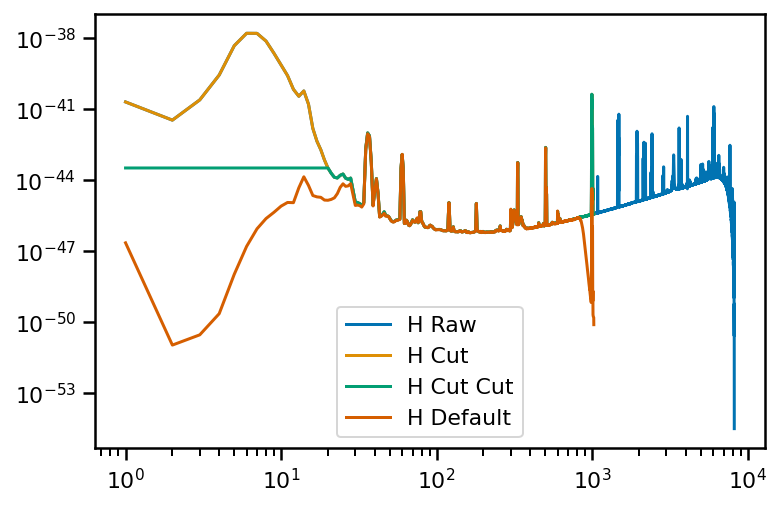

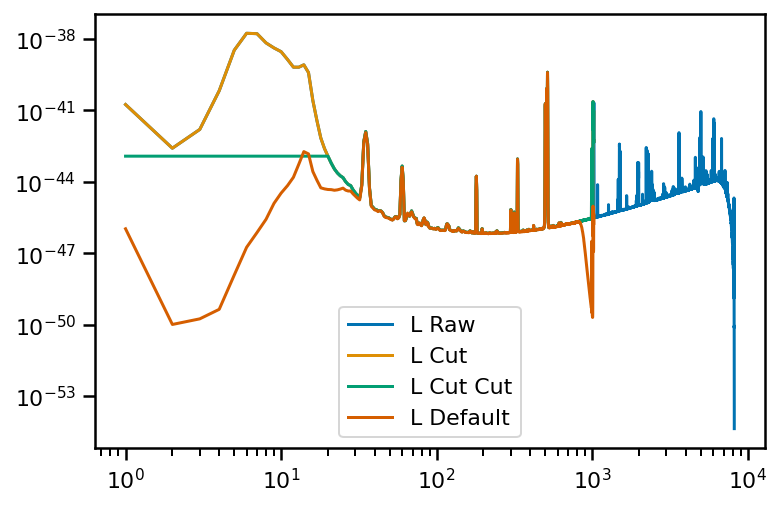

In [92]:
h_raw_psd.iloc[1:].plot(label='H Raw')
h_cut_psd.iloc[1:].plot(label='H Cut')
h_cut_cut_psd.iloc[1:].plot(label='H Cut Cut')
acfs_fd['H1'].to_psd().iloc[1:].plot(label='H Default')
yscale('log')
xscale('log')
legend()

figure()
l_raw_psd.iloc[1:].plot(label='L Raw')
l_cut_psd.iloc[1:].plot(label='L Cut')
l_cut_cut_psd.iloc[1:].plot(label='L Cut Cut')
acfs_fd['L1'].to_psd().iloc[1:].plot(label='L Default')
yscale('log')
xscale('log')
legend()

In [87]:
N = fit.n_analyze
whitened_snrs = {}
for k, v in acfs_fd_cut.items():
    data = v.whiten_segments(fit.data[k], N)
    whitened_snrs[k] = [np.dot(d,d)/len(d) for d in data]

(-2410.5, 50620.5, 0.5, 1.5)

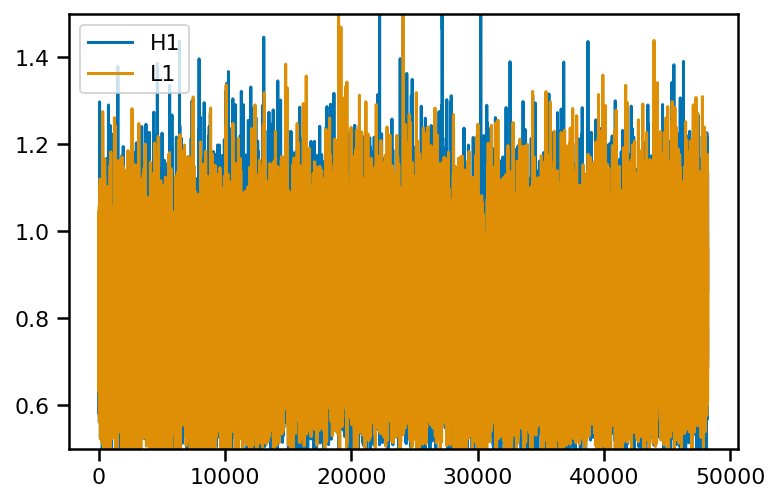

In [88]:
for k in whitened_snrs.keys():
    plot(whitened_snrs[k], label=k)
legend()
axis(ymin=0.5, ymax=1.5)

In [89]:
{k : mean(whitened_snrs[k]) for k in whitened_snrs.keys()}

{'H1': 0.8186886791796274, 'L1': 0.7990143749373338}

In [62]:
fit.n_analyze

87

In [63]:
from scipy.stats import chi2

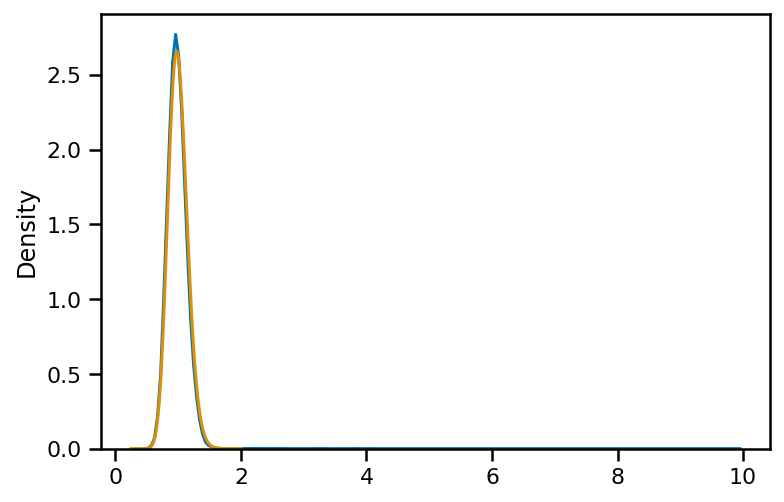

In [64]:
sns.kdeplot(whitened_snrs['H1'])
xs = linspace(0.25, 2, 1024)
plot(xs, chi2(fit.n_analyze, scale=1/fit.n_analyze).pdf(xs))